# **EDA and Performance Comparison between Spark and Pandas**

## **Spark Installation and setup**
### Run the cells below to install Spark and set the Environment Variables

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOMEfrom pyspark.sql import SparkSession

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# **Mounting the Google Drive**

Execute the following cell if you will be running the notebook in Google Colab. - The following code mounts your google drive in the colab notebook for you to access data stored on your drive. 
- If using google colab the dataset needs to be uploaded on your google drive and then the drive needs to be mounted with the following code. 
- When you run the following cell it asks you to go to a URL. Clicking on that it prompts you to chose your google account. 
- Select the account where your data is uploaded.
- Click on "Allow" to give necessary permissions.
- Copy the authentication code and paste in in the box below the URL and hit 'Enter'
- You will get the following message "Mounted at /content/drive" indicating that your drive is no mounted and ready to use 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Importing necessary Libraries**

In [5]:
import numpy as np
import pandas as pd 
import gc
import os

#Libraries for plotting
import matplotlib
import matplotlib.pyplot as plt  
import seaborn as sns

# To calculate time elapsed
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Data Folder path**
- If using Google Colab your path should start with "/content/drive/My Drive/" followed by folder name/path in which the data in uploaded.
- On local system use the path of folder where your data is located.

In [0]:
data_folder_path = '/content/drive/My Drive/Colab Notebooks/data'

## Reading Data using Pandas

In [0]:
aisles = pd.read_csv(data_folder_path + '/aisles.csv')
departments = pd.read_csv(data_folder_path + '/departments.csv')
order_products_prior = pd.read_csv(data_folder_path + '/order_products__prior.csv')
order_products_train = pd.read_csv(data_folder_path + '/order_products__train.csv')
orders = pd.read_csv(data_folder_path + '/orders.csv')
products = pd.read_csv(data_folder_path + '/products.csv')


## Reading Data using Spark

In [0]:
aisles_spark = spark.read.csv(data_folder_path +"/aisles.csv", header=True, inferSchema=True)
departments_spark = spark.read.csv(data_folder_path +"/departments.csv", header=True, inferSchema=True)
order_products_prior_spark = spark.read.csv(data_folder_path +"/order_products__prior.csv", header=True, inferSchema=True)
order_products_train_spark = spark.read.csv(data_folder_path +"/order_products__train.csv", header=True, inferSchema=True)
orders_spark = spark.read.csv(data_folder_path +"/orders.csv", header=True, inferSchema=True)
products_spark = spark.read.csv(data_folder_path +"/products.csv", header=True, inferSchema=True)

# Create Temporary Tables
aisles_spark.createOrReplaceTempView("aisles_spark")
departments_spark.createOrReplaceTempView("departments_spark")
order_products_prior_spark.createOrReplaceTempView("order_products_prior_spark")
order_products_train_spark.createOrReplaceTempView("order_products_train_spark")
orders_spark.createOrReplaceTempView("orders_spark")
products_spark.createOrReplaceTempView("products_spark")

# **Exploratory Data Analysis**

## 1. Orders placed per day for every day of the week

In [9]:
# Query 1 days of order in a week: Pandas
#timer started
tic = time.perf_counter()

#Main logic
orders_per_day_of_week = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
orders_per_day_of_week = orders_per_day_of_week.order_dow.value_counts()

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")



Time Required :  1.8732 seconds


In [10]:
# Query 1 days of order in a week: Spark
#timer started
tic = time.perf_counter()

#Main logic
query1="""select 
  count(order_id) as total_orders, 
  (case 
     when order_dow = '0' then 'Sunday'
     when order_dow = '1' then 'Monday'
     when order_dow = '2' then 'Tuesday'
     when order_dow = '3' then 'Wednesday'
     when order_dow = '4' then 'Thursday'
     when order_dow = '5' then 'Friday'
     when order_dow = '6' then 'Saturday'              
   end) as day_of_week 
  from orders_spark  
 group by order_dow 
 order by total_orders desc"""
eda1=spark.sql(query1)

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")

Time Required :  0.3256 seconds


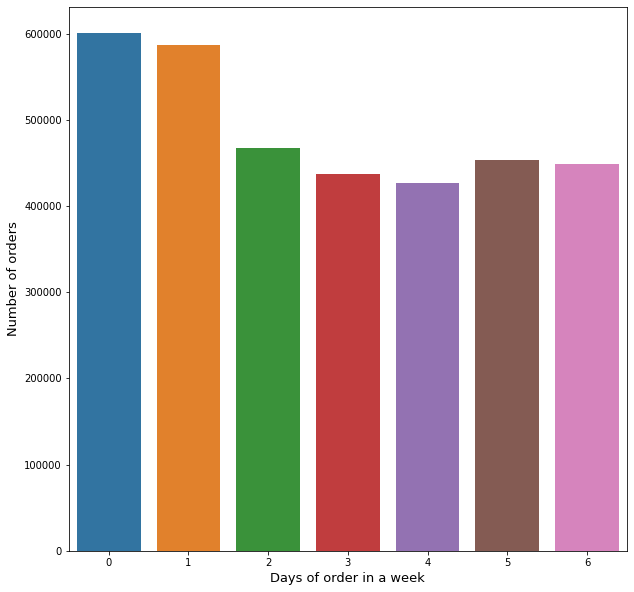

In [11]:
# Bar Plot Distribution of orders for every day of the week
f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(orders_per_day_of_week.index, orders_per_day_of_week.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

### The indexes of on X-axis represent the days of week with '0' being 'Sunday' and '6' being 'Saturday'
- We can see that the maximum orders are placed on Sunday followed by Monday and then a reducing trend up until Thurday. Friday and Saturday see almost the same number of orders placed.
- From this we can say that most people place orders on the weekend and/or on Monday. Whereas the flow of orders is less on the weekdays.

## 2. Number of orders placed per hour of the day

In [12]:
#query 2 Orders by hour of the day: Pandas
#timer started
tic = time.perf_counter()

#Main logic
orders_per_hour_of_day = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
orders_per_hour_of_day = orders_per_hour_of_day.order_hour_of_day.value_counts()

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")


Time Required :  1.8509 seconds


In [13]:
#query 2 Orders by hour of the day: Spark
#timer started
tic = time.perf_counter()

#Main logic
query2="""select 
  count(order_id) as total_orders, 
  order_hour_of_day as hour 
  from orders_spark 
 group by order_hour_of_day 
 order by order_hour_of_day"""

#timer ends
eda2=spark.sql(query2)
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")


Time Required :  0.0191 seconds


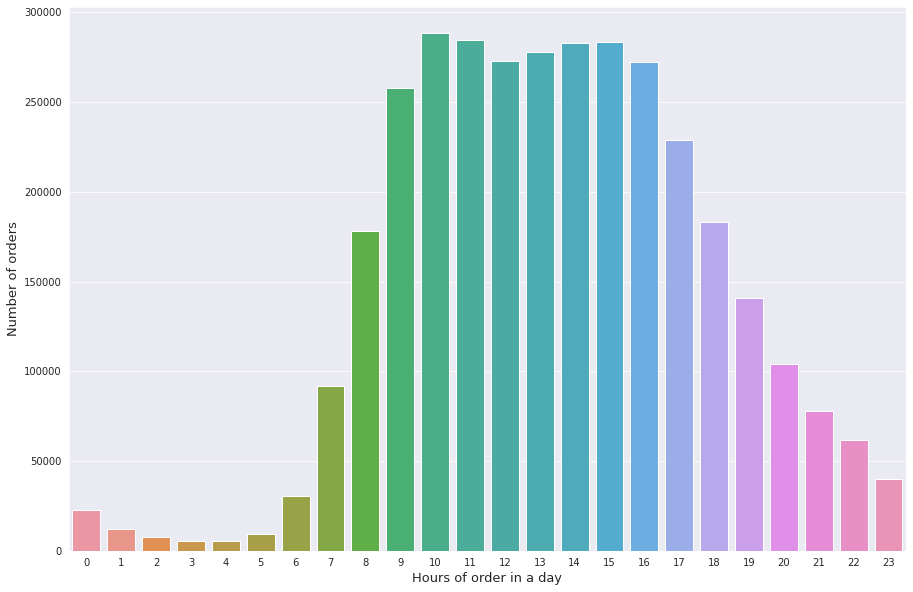

In [14]:
# Bar Plot distribution for every hour of the day
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(orders_per_hour_of_day.index, orders_per_hour_of_day.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

-  Based on the above distribution we can see that the maximum number of orders are placed between 8:00 am to 7:00 pm.
- Very few orders are placed before 7:00 am
- The number of orders is less after 8:00 pm but not as low as the number of orders placed before 7:00 am.
- 10:00 am seems to be the ideal time for placing orders for most of the customers.

## 3. Finding the most popular departments

In [15]:
# query 3 Most popular departments:Pandas
#timer started
tic = time.perf_counter()

#Main logic
# Merging the aisles,departments and products dataframe to get the necessary data together
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')

# Grouping the data together based on 'product id' and 'department name'
# This is done to find out total products ordered from every department and based on the popular departments are determined
popular_departments = items.groupby("department")["product_id"].count().reset_index()
popular_departments = pd.DataFrame(popular_departments).reset_index(drop = True)
popular_departments.columns = ['department','product_id']
popular_departments.rename(columns={'product_id' : 'Total_products'},inplace = True)
popular_departments.sort_values(by = ['Total_products'], ascending=False, inplace=True)

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")

popular_departments

Time Required :  0.0419 seconds


,department,Total_products
17,personal care,6563
20,snacks,6264
16,pantry,5371
3,beverages,4365
10,frozen,4007
7,dairy eggs,3449
11,household,3085
6,canned goods,2092
9,dry goods pasta,1858
19,produce,1684


In [16]:
# query 3 Most popular departments: Spark 
#timer started
tic = time.perf_counter()

#Main logic
query3="""select countbydept.*
  from (

  select department_id, count(1) as counter
    from products_spark
   group by department_id
   order by counter asc 
  ) as maxcount
inner join ( 
  select
    d.department_id,
    d.department,
    count(1) as products
    from departments_spark d
      inner join products_spark p
         on p.department_id = d.department_id
   group by d.department_id, d.department 
   order by products desc
  ) countbydept 
  on countbydept.products = maxcount.counter"""

#timer ends
eda3=spark.sql(query3)
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")
eda3.show()


Time Required :  0.1691 seconds
+-------------+---------------+--------+
|department_id|     department|products|
+-------------+---------------+--------+
|           11|  personal care|    6563|
|           19|         snacks|    6264|
|           13|         pantry|    5371|
|            7|      beverages|    4365|
|            1|         frozen|    4007|
|           16|     dairy eggs|    3449|
|           17|      household|    3084|
|           15|   canned goods|    2092|
|            9|dry goods pasta|    1858|
|            4|        produce|    1684|
|            3|         bakery|    1516|
|           20|           deli|    1322|
|           21|        missing|    1258|
|            6|  international|    1139|
|           14|      breakfast|    1115|
|           18|         babies|    1081|
|            5|        alcohol|    1054|
|            8|           pets|     972|
|           12|   meat seafood|     907|
|            2|          other|     548|
+-------------+----------

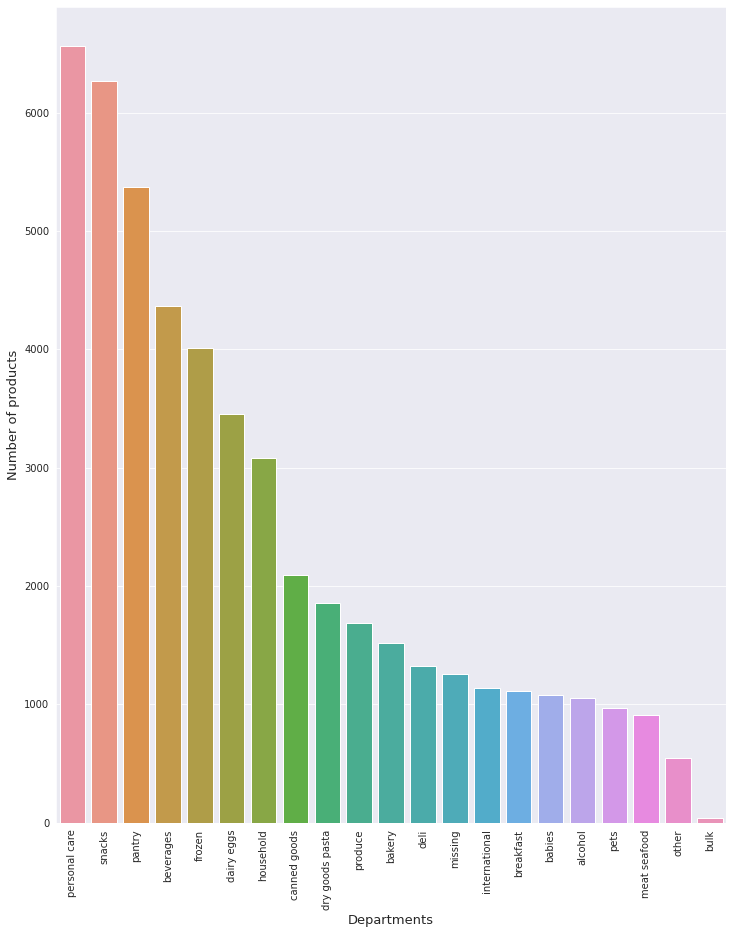

In [17]:
# Bar plot
popular_departments  = popular_departments.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(popular_departments.index, popular_departments.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

- Based on the above distribution 'personal care' departments seems to be the most popular department.
- Though departments like 'snacks','pantry','beverages','frozen','dairy eggs','household' also have significantly higher orders.
- The 'bulk' department id the least popular. This tells us that most of the people are not interested in buying things in bulk.

## 4. Finding the Most popular products

In [18]:
# Query 4 Most popular products: Pandas
#timer started
tic = time.perf_counter()

#Main logic
# Grouping the data together based on 'product id' and 'department name'
# This is done to find out total products ordered from every department and based on the popular departments are determined

popular_products = pd.merge(order_products_prior, products, on='product_id', how='left')
popular_products = pd.merge(popular_products, aisles, on='aisle_id', how='left')
popular_products = pd.merge(popular_products, departments, on='department_id', how='left')
product_count = popular_products['product_name'].value_counts().reset_index().head(20)
product_count.columns = ['product_name', 'frequency_count']

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")


#displaying top 20 popular products
product_count

Time Required :  15.8148 seconds


,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


In [19]:
# Query 4 Most popular products: Spark
#timer Started
tic = time.perf_counter()

query4="""select count(opp.order_id) as orders, p.product_name as popular_product
  from order_products_prior_spark opp, products_spark p
 where p.product_id = opp.product_id 
 group by popular_product 
 order by orders desc 
 limit 20"""
eda4=spark.sql(query4)

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")

#displaying top 20 popular products
eda4.show()

Time Required :  0.0488 seconds
+------+--------------------+
|orders|     popular_product|
+------+--------------------+
|472565|              Banana|
|379450|Bag of Organic Ba...|
|264683|Organic Strawberries|
|241921|Organic Baby Spinach|
|213584|Organic Hass Avocado|
|176815|     Organic Avocado|
|152657|         Large Lemon|
|142951|        Strawberries|
|140627|               Limes|
|137905|  Organic Whole Milk|
|137057| Organic Raspberries|
|113426|Organic Yellow Onion|
|109778|      Organic Garlic|
|104823|    Organic Zucchini|
|100060| Organic Blueberries|
| 97315|      Cucumber Kirby|
| 89632|  Organic Fuji Apple|
| 87746|       Organic Lemon|
| 85020|Apple Honeycrisp ...|
| 84255|Organic Grape Tom...|
+------+--------------------+



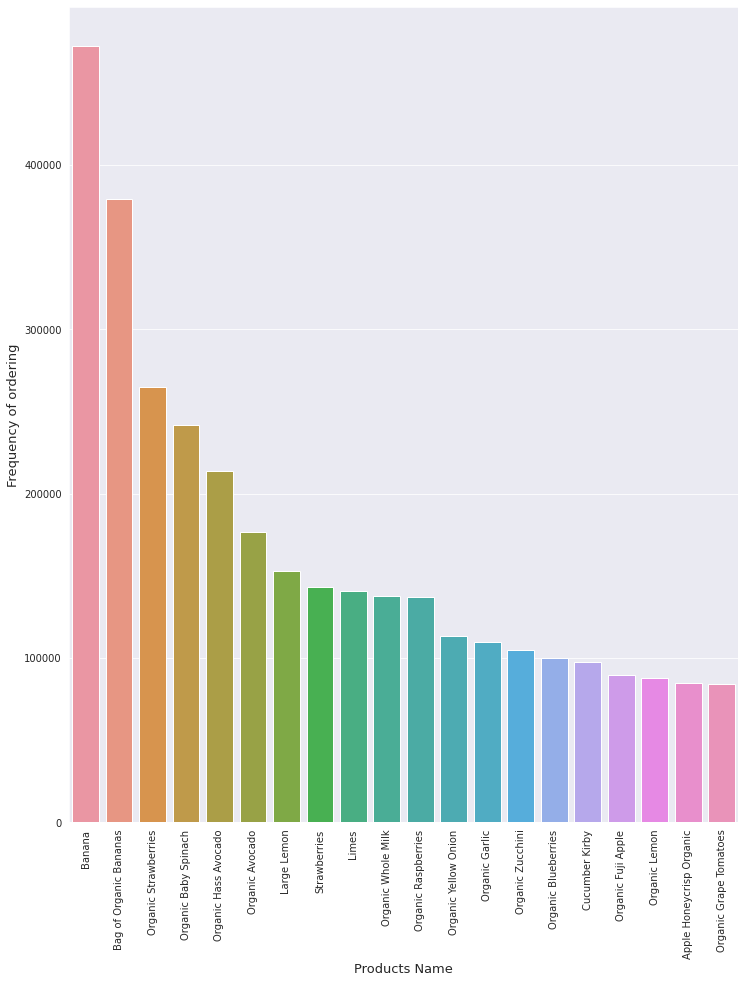

In [20]:
# Bar Plot 
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(product_count.product_name, product_count.frequency_count)
plt.xlabel('Products Name', fontsize=13)
plt.ylabel('Frequency of ordering', fontsize=13)
plt.show()

- From the above graph we can say the most of the popular or frequently ordered items are fruits and vegetables
- Second observation is that most of the products are organic.
- From this we can say that most people are inclined towards organic produce.

## 5. Department-wise distribution of popular products

In [21]:
# Query 5 Department-wise distribution based on popular products: Pandas
#timer started
tic = time.perf_counter()

# Main logic
# Merging the necessary dataframes to get the required data
popular_products = pd.merge(order_products_prior, products, on='product_id', how='left')
popular_products = pd.merge(popular_products, aisles, on='aisle_id', how='left')
popular_products = pd.merge(popular_products, departments, on='department_id', how='left')

# Grouping the popular products by department and taking top 10 departments. 
# These departments have the most number of popular products ordered.
temp_series = popular_products['department'].value_counts().head(10)
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")

Time Required :  14.6731 seconds


In [22]:
# Query 5 Department-wise distribution based on popular products: Spark
#timer started
tic = time.perf_counter()

#Main Logic
query5=""" SELECT department,count(p.department_id) as products
FROM products_spark p
LEFT JOIN order_products_prior_spark opp
    on opp.product_id = p.product_id
LEFT JOIN aisles_spark a
    on a.aisle_id = p.aisle_id
LEFT JOIN departments_spark d
    on d.department_id = p.department_id
group by d.department
order by products desc
limit 10
"""
eda5=spark.sql(query5)

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")

Time Required :  0.0400 seconds


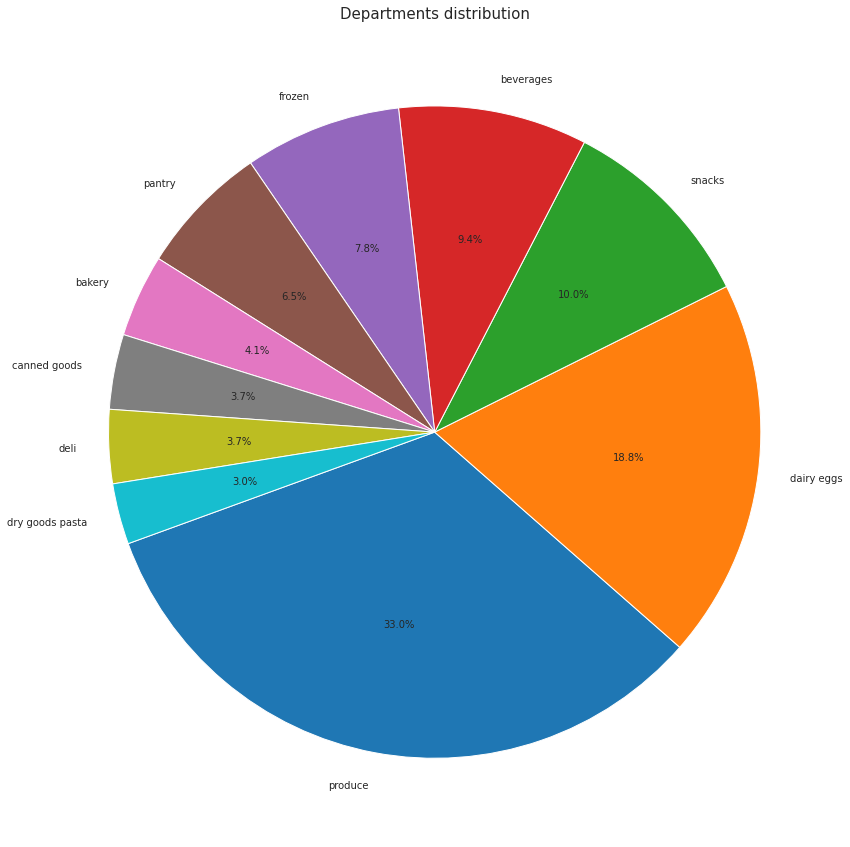

In [23]:

# Pie Chart for the distribution
plt.figure(figsize=(15,15))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

- From the above chart it is clear that most of the popular products are from the "Produce' department.
- This goes in line with fact that most of the top popular products where either fruits or vegetables in our previous query.

## 6. Most Important Aisles in each Department

In [24]:
#Query 6 Most important aisles in each department: Pandas
#timer started
tic = time.perf_counter()

# Main logic
# Grouping the dataframe based on department, aisle and product id

important_aisles = items.groupby(["department", "aisle"])["product_id"].count().reset_index()
important_aisles = pd.DataFrame(important_aisles).reset_index(drop = True)
important_aisles.columns = ['department','aisle','product_id']
important_aisles.rename(columns={'product_id' : 'Total_products'},inplace = True)
important_aisles.sort_values(by='Total_products', ascending=False, inplace=True)


#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")


Time Required :  0.0188 seconds


In [25]:
#Query 6 Most important aisles in each department: Spark
#timer started
tic = time.perf_counter()

#Main Logic
query6=""" SELECT d.department,  count(distinct p.product_id) as total_product,a.aisle
FROM products_spark p
INNER JOIN departments_spark d
    on p.department_id = d.department_id
INNER JOIN aisles_spark a
    on p.aisle_id = a.aisle_id
group by d.department,a.aisle
"""
eda6=spark.sql(query6)

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")


Time Required :  0.0280 seconds


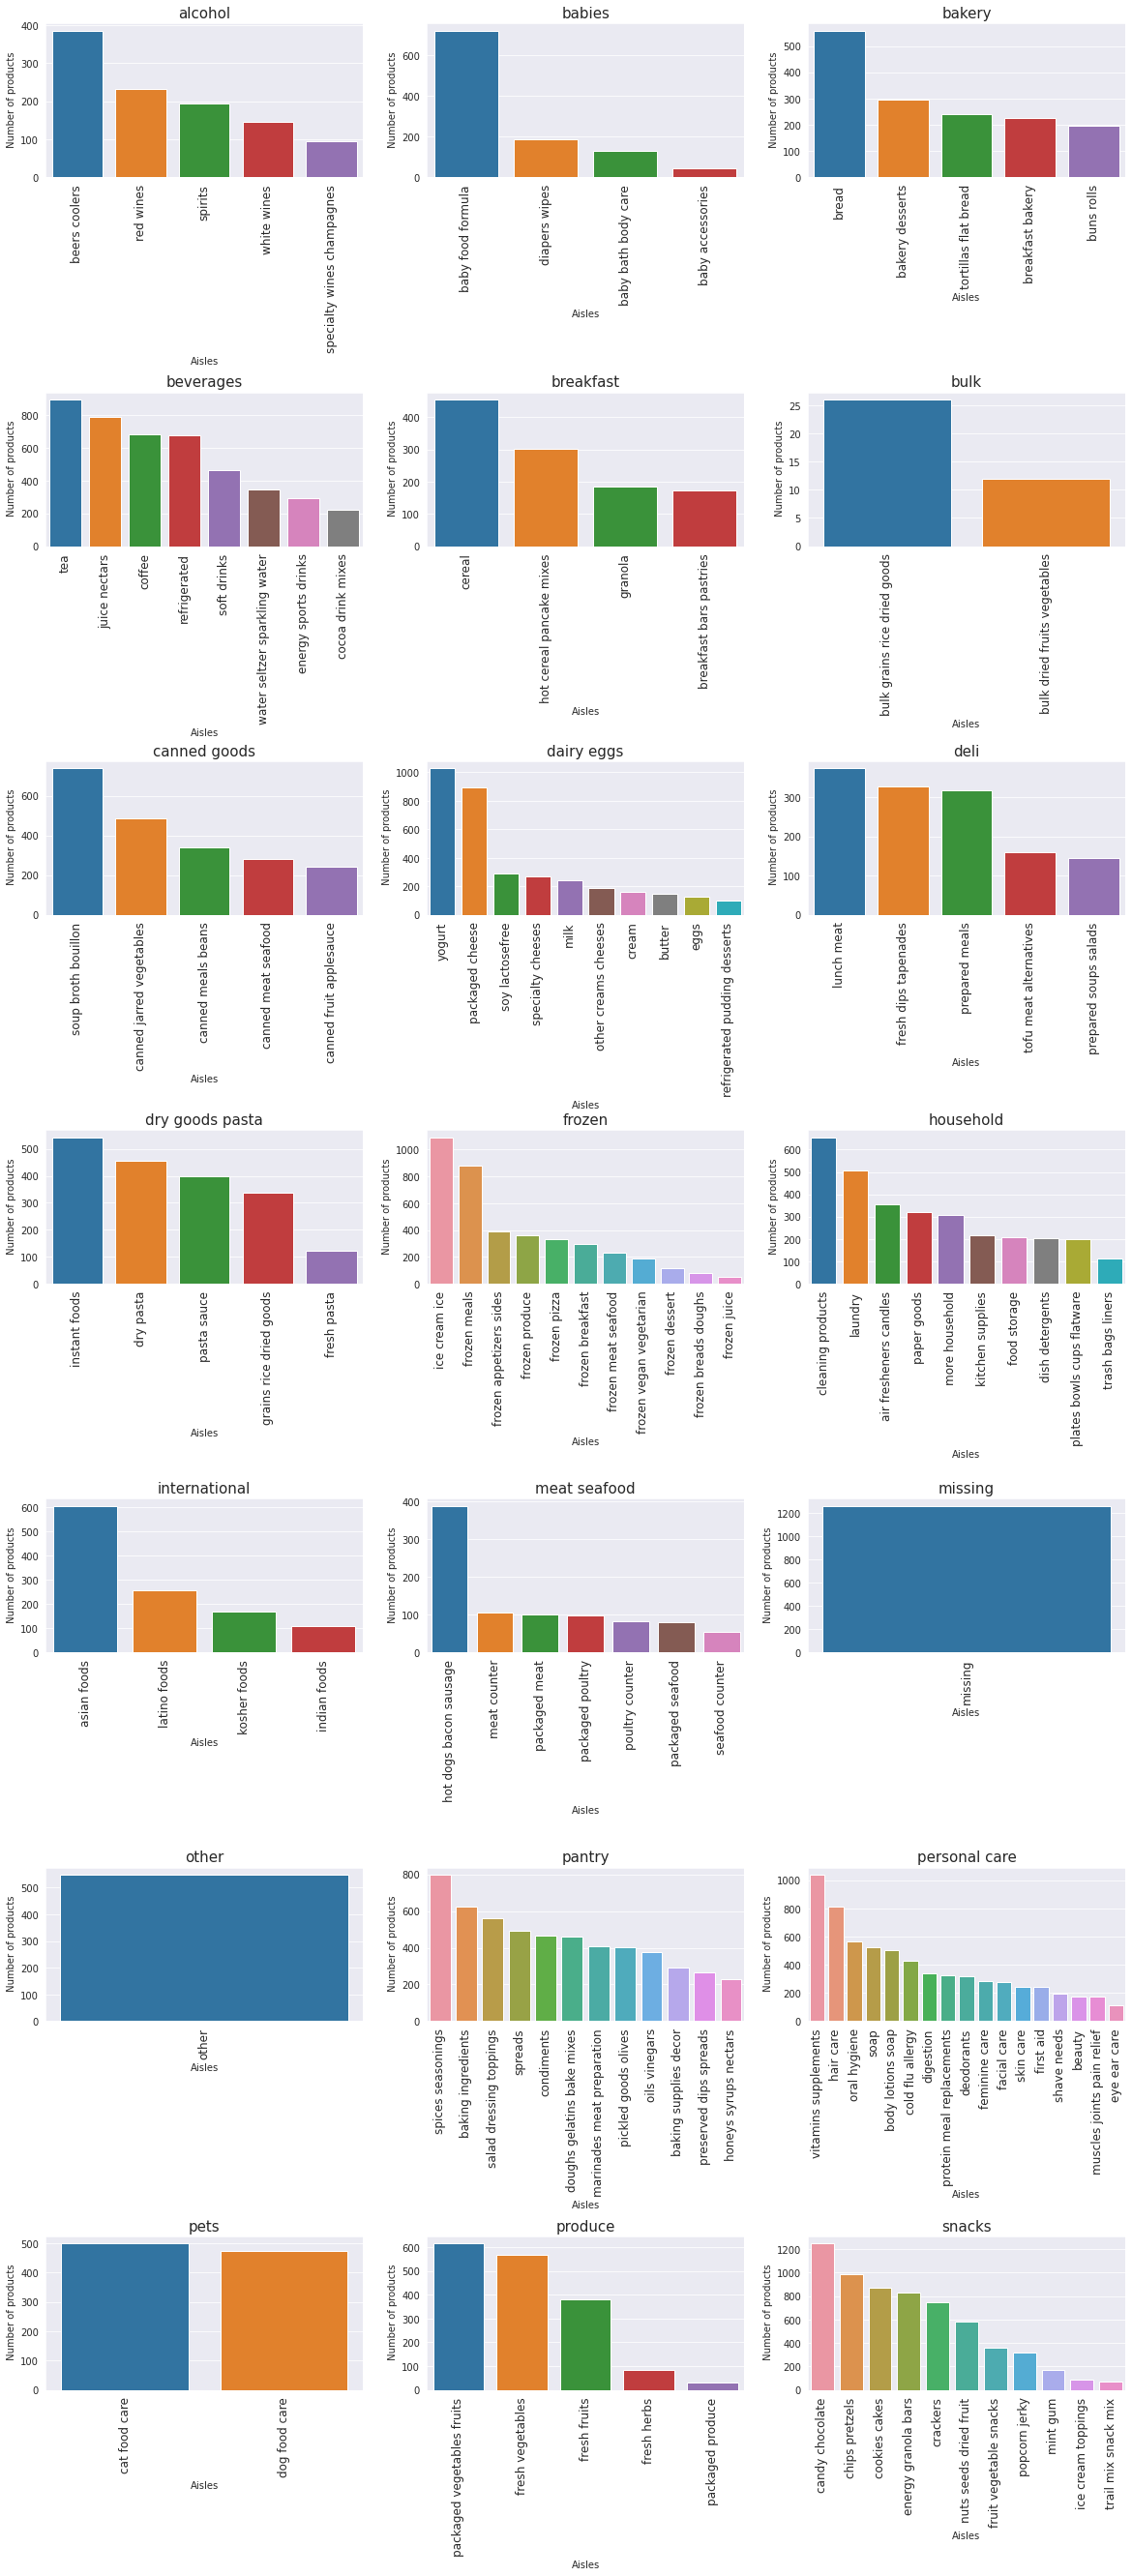

In [26]:
# Bar Plots for popular aisles in every department
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(important_aisles.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

- The above set of Bar Graphs shows the important aisles in every department based on ordered products.

## 7. Total Orders and Re-Orders from popular aisles

In [27]:
#Query 7 Total Orders and Re-Orders from Popular aisles: Pandas
#timer started
tic = time.perf_counter()

# Main logic
# Merging the necessary Dataframes to get the required data

ordered_products = order_products_train.merge(products, on ='product_id', how='left')
ordered_products = ordered_products.merge(aisles, on ='aisle_id', how='left')
ordered_products = ordered_products.merge(departments, on ='department_id', how='left')
ordered_products = ordered_products.merge(orders, on='order_id', how='left')
temp_df = ordered_products.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")

Time Required :  1.7975 seconds


In [28]:
#Query 7 Total Orders and Re-Orders from Popular aisles: Spark
#timer started
tic = time.perf_counter()

# Main logic
query7=""" SELECT aisle,count(op.reordered) as total ,sum(op.reordered) as reorder
FROM order_products_train_spark op
LEFT JOIN products_spark p
    on p.product_id = op.product_id
LEFT JOIN aisles_spark a
    on a.aisle_id = p.aisle_id
LEFT JOIN departments_spark d
    on d.department_id = p.department_id
LEFT JOIN orders_spark o
    on o.order_id = op.order_id
group by a.aisle
"""
eda7=spark.sql(query7)

#timer ends
toc = time.perf_counter()
print(f"Time Required :  {toc - tic:0.4f} seconds")

Time Required :  0.0478 seconds


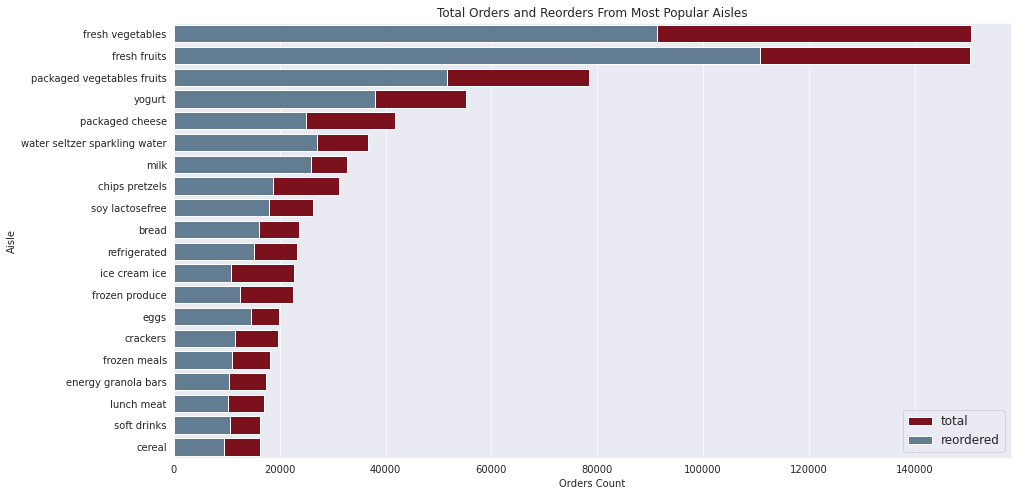

In [29]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.total[0:20], color=sns.xkcd_rgb["crimson"], label = "total")
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.reorders[0:20], color=sns.xkcd_rgb["steel blue"], label = "reordered")
ax.set_ylabel("Aisle")
ax.set_xlabel("Orders Count")
ax.set_title("Total Orders and Reorders From Most Popular Aisles")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

- The above graph compares the total orders for a products by the number of re-orders for the same products.
- We can see that fresh fruits and fresh vegetables have the highest number of re-orders.

##Performance Comparison between Spark and Pandas



*   On Comparing the above EDA queries on the basis of time we can say that in most of the queries Spark is gives results faster than Pandas.
*   Pandas dataframes are in-memory and the advantages of using Pandas are: Pandas dataframe are support more libs, simpler, more flexible, easier to implement complex algorithm on them.
*   Spark SQL data frames are not in-memory instead of table it generates views and are distributed on spark cluster so their size is limited by the size of your cluster.


 
